In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import json, pickle
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
word2vec_model = Word2Vec.load("../../data/commons/word2vec.model")

In [3]:
post_id_2_text = pickle.load(open("../../data/non-graph/posts_id_2_text.pkl", "rb"))

In [16]:
post2user = pickle.load(open("../../data/non-graph/post_id_2_user_id.pkl", "rb"))
user2posts = pickle.load(open("../../data/non-graph/user_id_posts_idx_list.pkl", "rb"))
for post_id in tqdm(post2user):
    post_ids = set(user2posts[post2user[post_id]])
    post_ids.add(post_id)
    post2user[post_id] = sorted(list(post_ids))

100%|██████████| 10423/10423 [00:11<00:00, 937.58it/s] 


In [9]:
class Encoder(nn.Module):

    def __init__(self, seq_len, inp_dim):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.inp_dim = inp_dim

        self.rnn = nn.LSTM(inp_dim, inp_dim, 2, batch_first=True, bidirectional=False)
    
    def forward(self, x):
        assert x.shape[1] == self.seq_len
        assert x.shape[2] == self.inp_dim

        x, _ = self.rnn(x)
        return x

In [10]:
class Classifier(nn.Module):
    
    def __init__(self, inp_dim, out_logits):
        super(Classifier, self).__init__()

        self.inp_dim = inp_dim
        self.out_dim = out_logits

        self.fc = nn.Linear(inp_dim, out_logits)
    
    def forward(self, x):
        assert x.shape[1] == self.inp_dim

        x = self.fc(x)
        return torch.log_softmax(x, dim=1)

In [28]:
def get_contrastive_batches(post_ids, device, batch_size):
    num_of_batches = post_ids.shape[0] // batch_size + (1 if post_ids.shape[0] % batch_size else 0)
    shuffled_idxs = np.random.permutation(np.arange(post_ids.shape[0]))
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_idxs.shape[0], 11, max_len, dim), dtype=np.float32)
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = int(post_ids[batch_idx][:-4])
            user_id = post2user[post_id]
            positive_sample = post_id
            while positive_sample != post_id:
                positive_sample = np.random.choice(user2posts[user_id])#[:-4]
            batch_post_ids = [post_id, positive_sample]
            negative_user_ids = [userid for userid in user2posts if userid != user_id]
            negative_users = set()
            negative_samples = []
            while len(negative_users) < 9:
                negative_users.add(np.random.choice(negative_user_ids))
            for userid in list(negative_users):
                negative_samples.append(np.random.choice(user2posts[userid]))
            batch_post_ids.extend(list(negative_samples))
            for dim2, post_id in enumerate(batch_post_ids):
                vecs = []
                for word in post_id_2_text[int(post_id)].split():
                    try:
                        vecs.append(word2vec_model.wv.get_vector(word))
                    except:
                        pass
                sent_len = len(vecs)
                if sent_len >= max_len:
                    vecs = vecs[:max_len]
                else:
                    pad_len = max_len - sent_len
                    pad_vecs = []
                    for _ in range(pad_len):
                        pad_vecs.append(np.zeros((dim,)))
                    vecs = pad_vecs + vecs
                X[dim1, dim2] = np.array(vecs)
        yield torch.FloatTensor(X).to(device)

In [18]:
def get_batches(post_ids, y, device, batch_size):
    num_of_batches = y.shape[0] // batch_size + (1 if y.shape[0] % batch_size else 0)
    shuffled_idxs = np.random.permutation(np.arange(y.shape[0]))
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_idxs.shape[0], 1, max_len, dim), dtype=np.float32)
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = int(post_ids[batch_idx][:-4])
            batch_post_ids = [post_id]
            for dim2, post_id in enumerate(batch_post_ids):
                vecs = []
                for word in post_id_2_text[post_id].split():
                    try:
                        vecs.append(word2vec_model.wv.get_vector(word))
                    except:
                        pass
                sent_len = len(vecs)
                if sent_len >= max_len:
                    vecs = vecs[:max_len]
                else:
                    pad_len = max_len - sent_len
                    pad_vecs = []
                    for _ in range(pad_len):
                        pad_vecs.append(np.zeros((dim,)))
                    vecs = pad_vecs + vecs
                X[dim1, dim2] = np.array(vecs)
        yield torch.FloatTensor(X.squeeze()).to(device),\
                torch.LongTensor(y[batch_idxs]).to(device)

In [23]:
def contrastive_train(epoch_num, data, device, optimizer, criterion, model, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    model.train()
    losses = []
    for i, batch in enumerate(tqdm(get_contrastive_batches(data, device, batch_size),
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0))):
        out = model(batch[:,0]).reshape(batch.shape[0], -1)
        similarities = torch.zeros(batch.shape[0], batch.shape[1]).to(device)
        for j in range(1, batch.shape[1]):
            with torch.no_grad():
                out2 = model(batch[:,j]).reshape(batch.shape[0], -1)
            similarities[:, j-1] = torch.mul(out, out2).sum(dim=1)
        loss = criterion(torch.log_softmax(similarities, dim=1), torch.zeros(batch.shape[0], dtype=int).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if verbose:
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss:", round(loss.item(), 4))
    model.eval()
    return losses

In [33]:
def label_train(epoch_num, data, labels, device, optimizer, criterion, enc, clf, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    enc.eval()
    clf.train()
    losses = []
    for i, batch in enumerate(tqdm(get_batches(data, labels, device, batch_size),
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0))):
        with torch.no_grad():
            inp = enc(batch[0]).reshape(batch[0].shape[0], -1)
        out = clf(inp)
        loss = criterion(out, batch[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if verbose:
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss:", round(loss.item(), 4))
    clf.eval()
    return losses

In [36]:
def evaluate(epoch_num, data, labels, device, enc, clf, batch_size=64):
    print("Evaluating | Epoch:", epoch_num)
    y_preds = []
    y_tests = []
    for batch in get_batches(data, labels, device, batch_size):
        with torch.no_grad():
            inp = enc(batch[0]).reshape(batch[0].shape[0], -1)
        out = clf(inp)
        for y in batch[1].cpu().numpy():
            y_tests.append(y)
        for y in out.argmax(dim=1).cpu().numpy():
            y_preds.append(y)
    print(classification_report(y_tests, y_preds))

In [21]:
def get_ids_and_labels(split):
    ids = [i for i in pid[split] if 'gab' in i]
    labels = [label_dict[Counter([j["label"] for j in data[i]["annotators"]]).most_common(1)[0][0]] for i in pid[split] if 'gab' in i]
    return np.array(ids), np.array(labels)

In [22]:
data_path = '../../data/commons/dataset.json'
pid_path = '../../data/commons/post_id_divisions.json'

with open(pid_path) as f:
    pid = json.load(f)
with open(data_path) as f:
    data = json.load(f)

label_dict = {'normal': 0, 'offensive': 1, 'hatespeech': 2}

train_ids, train_labels = get_ids_and_labels("train")
val_ids, val_labels = get_ids_and_labels("val")
test_ids, test_labels = get_ids_and_labels("test")

Training | Epoch: 1


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 2


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]


Training | Epoch: 3


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 4


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 5


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]


Training | Epoch: 6


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 7


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 8


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 9


100%|██████████| 66/66 [00:36<00:00,  1.80it/s]


Training | Epoch: 10


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 11


100%|██████████| 66/66 [00:37<00:00,  1.75it/s]


Training | Epoch: 12


100%|██████████| 66/66 [00:37<00:00,  1.78it/s]


Training | Epoch: 13


100%|██████████| 66/66 [00:37<00:00,  1.78it/s]


Training | Epoch: 14


100%|██████████| 66/66 [00:36<00:00,  1.79it/s]


Training | Epoch: 15


100%|██████████| 66/66 [00:36<00:00,  1.79it/s]


Training | Epoch: 16


100%|██████████| 66/66 [00:36<00:00,  1.79it/s]


Training | Epoch: 17


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 18


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Training | Epoch: 19


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]


Training | Epoch: 20


100%|██████████| 66/66 [00:37<00:00,  1.78it/s]


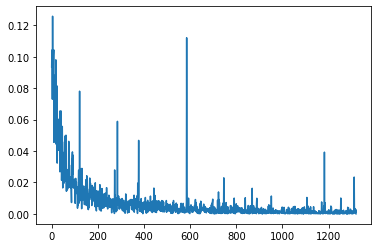

In [30]:
max_len = 70
dim = 200
encoder = Encoder(70, 200).to(torch.device("cuda:0"))
optimizer = optim.Adam(encoder.parameters(), lr=3e-5)
criterion = nn.NLLLoss()
losses = []
for i in range(20):
    losses.extend(contrastive_train(i+1, train_ids, torch.device("cuda:0"), optimizer, criterion, encoder, 128))
plt.plot(losses)
plt.show()

Training | Epoch: 11


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]


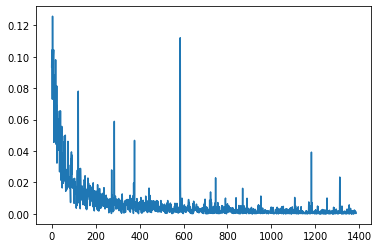

In [32]:
losses.extend(contrastive_train(21, train_ids, torch.device("cuda:0"), optimizer, criterion, encoder, 128))
plt.plot(losses)
plt.show()
torch.save(encoder.state_dict(), "encoder_user_NLL.pth")

Training | Epoch: 1


100%|██████████| 66/66 [00:00<00:00, 71.83it/s]


Training | Epoch: 2


100%|██████████| 66/66 [00:00<00:00, 71.32it/s]


Training | Epoch: 3


100%|██████████| 66/66 [00:00<00:00, 71.51it/s]


Training | Epoch: 4


100%|██████████| 66/66 [00:00<00:00, 71.52it/s]


Training | Epoch: 5


100%|██████████| 66/66 [00:00<00:00, 72.00it/s]


Training | Epoch: 6


100%|██████████| 66/66 [00:00<00:00, 71.70it/s]


Training | Epoch: 7


100%|██████████| 66/66 [00:00<00:00, 70.42it/s]


Training | Epoch: 8


100%|██████████| 66/66 [00:00<00:00, 71.47it/s]


Training | Epoch: 9


100%|██████████| 66/66 [00:00<00:00, 71.94it/s]


Training | Epoch: 10


100%|██████████| 66/66 [00:00<00:00, 72.12it/s]


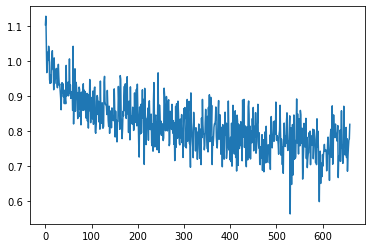

In [38]:
classifier = Classifier(70*200, 3).to(torch.device("cuda:0"))
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
losses = []
for i in range(10):
    losses.extend(label_train(i+1, train_ids, train_labels, torch.device("cuda:0"), optimizer, criterion, encoder, classifier, 128))
plt.plot(losses)
plt.show()

In [39]:
evaluate(-1, test_ids, test_labels, torch.device("cuda:0"), encoder, classifier, batch_size=512)

Evaluating | Epoch: -1
              precision    recall  f1-score   support

           0       0.54      0.40      0.46       216
           1       0.45      0.34      0.39       305
           2       0.66      0.83      0.74       515

    accuracy                           0.60      1036
   macro avg       0.55      0.52      0.53      1036
weighted avg       0.58      0.60      0.58      1036

